In [ ]:
import os
import math
from math import *
import time
import glob
import random
import pygame
import cProfile
import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import grad

import linecache
import tracemalloc
from tracemalloc import Snapshot

import gym
from gym import spaces, logger, error, utils
from gym.utils import seeding
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset

from datetime import datetime
from typing import Optional, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from IPython.display import HTML

In [ ]:
%matplotlib inline
mpl.rc('animation', html='jshtml')

def plotValue(vals_list: list[list[float]], xlabel="trials", ylabel="value") -> None:
    plt.figure()
    for vals in vals_list:
      plt.plot(vals, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_animation_simple(frames, name, repeat=False, interval=40):
    fig, ax = plt.subplots(figsize=(10, 7.5))
    patch = plt.imshow(frames[0])
    plt.axis('off')
    # Use lambda to update the frame directly without the need for a separate update_scene function
    anim = animation.FuncAnimation(
        fig, lambda num, patch: patch.set_data(frames[num]), fargs=(patch,),
        frames=len(frames), repeat=repeat, interval=interval)
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=25, metadata=dict(artist='Me'), bitrate=1800)
    anim.save(name, writer=writer)

    plt.close()
    return anim

def plotError(rewards: list[float]) -> None:

    print("     ")
    print("-----")
    print("Mean: ", np.mean(rewards))
    print("STD: ", np.std(rewards))
    print("Min: ", np.min(rewards))
    print("Max: ", np.max(rewards))
    print("-----")


    plt.figure()
    plt.hist(rewards, bins=30, color='skyblue', edgecolor='black')
    plt.axvline(np.array(rewards).mean(), color='k', linestyle='dashed', linewidth=1)
    plt.xlabel("episode")
    plt.ylabel("reward")
    plt.show()

def visualize_action_output(actor, x_range, theta_range, resolution=100):
    x_values = np.linspace(x_range[0], x_range[1], resolution)
    theta_values = np.linspace(theta_range[0], theta_range[1], resolution)
    action_outputs = np.zeros((resolution, resolution))

    for i, x in enumerate(x_values):
        for j, theta in enumerate(theta_values):
            state = torch.tensor([[x, theta, 0, 0]], dtype=torch.float)
            with torch.no_grad():
                action = actor(state)
                #print("action, "+str(action))
            action_outputs[j, i] = action

    plt.figure(figsize=(10, 6))
    X, Y = np.meshgrid(x_values, theta_values)
    plt.contourf(X, Y, action_outputs, 20, cmap='RdYlBu')
    plt.colorbar()
    plt.xlabel('radius')
    plt.ylabel('theta')
    plt.title('Action Output Visualization')
    plt.show()

In [ ]:
screen_size = (1024*2, 768*2)
startNumShips = 1
bhGravityEventHorizonRadius = 20.
bhGravityMinRadius = 20.
shipGravityMinRadius = 5.
shipPositions = [] # Updated in Asteroids.py::playGame()
shipColor = (255, 20, 20)

# SysParams={'G': 4*jnp.pi**2,
#            'M': 1.,                                  # Mass of the black hole.
#            'm': 1/50.,                               # Mass of the mass orbiting black hole.
#            'dt': 1/500.,                             # Step size.
#            'T': 10.,                                 # Number of periods the simulate will go through.
#            'initPos': jnp.array([ 0., 1., 0., 0.])   # Initial positions of BH and the mass [x_m, y_m, x_bh, y_bh].
#             }

# def OrbitVel(ParamDict):
#     G,M,pos_m = ParamDict['G'],ParamDict['M'],ParamDict['initPos']
#     x,y = pos_m[0],pos_m[1]
#     r = np.sqrt(x**2+y**2)
#     v = np.sqrt(G*M/r)
#     return v*y/r,-v*x/r

# # Initial positions of BH and the mass [vx_m, vy_m, vx_bh, vy_bh]. By default clockwise.
# initVel_m = OrbitVel(SysParams)
# SysParams['initVel'] = jnp.array([initVel_m[0], initVel_m[1], 0., 0.])

def calculateGradient(p1, p2):
    # Ensure that the line is not vertical
    if (p1[0] != p2[0]):
        m = (p1[1] - p2[1]) / (p1[0] - p2[0])
        return m
    else:
        return None

def calculateYAxisIntersect(p, m):
    return p[1] - (m * p[0])

def getIntersectPoint(p1, p2, p3, p4):
    m1 = calculateGradient(p1, p2)
    m2 = calculateGradient(p3, p4)

    # See if the the lines are parallel
    if (m1 != m2):
        # Not parallel

        # See if either line is vertical
        if (m1 is not None and m2 is not None):
            # Neither line vertical
            b1 = calculateYAxisIntersect(p1, m1)
            b2 = calculateYAxisIntersect(p3, m2)
            x = (b2 - b1) / (m1 - m2)
            y = (m1 * x) + b1
        else:
            # Line 1 is vertical so use line 2's values
            if (m1 is None):
                b2 = calculateYAxisIntersect(p3, m2)
                x = p1[0]
                y = (m2 * x) + b2
            # Line 2 is vertical so use line 1's values
            elif (m2 is None):
                b1 = calculateYAxisIntersect(p1, m1)
                x = p3[0]
                y = (m1 * x) + b1
            else:
                assert False

        return ((x, y),)
    else:
        b1, b2 = None, None  # vertical lines have no b value
        if m1 is not None:
            b1 = calculateYAxisIntersect(p1, m1)

        if m2 is not None:
            b2 = calculateYAxisIntersect(p3, m2)

        # If these parallel lines lay on one another
        if b1 == b2:
            return p1, p2, p3, p4
        else:
            return None


def calculateIntersectPoint(p1, p2, p3, p4):
    p = getIntersectPoint(p1, p2, p3, p4)
    if p is not None:
        width = p2[0] - p1[0]
        height = p2[1] - p1[1]
        r1 = pygame.Rect(p1, (width, height))
        r1.normalize()

        width = p4[0] - p3[0]
        height = p4[1] - p3[1]
        r2 = pygame.Rect(p3, (width, height))
        r2.normalize()

        # Ensure both rects have a width and height of at least 'tolerance' else the
        # collidepoint check of the Rect class will fail as it doesn't include the bottom
        # and right hand side 'pixels' of the rectangle
        tolerance = 1
        if r1.width < tolerance:
            r1.width = tolerance

        if r1.height < tolerance:
            r1.height = tolerance

        if r2.width < tolerance:
            r2.width = tolerance

        if r2.height < tolerance:
            r2.height = tolerance

        for point in p:
            try:
                res1 = r1.collidepoint(point)
                res2 = r2.collidepoint(point)
                if res1 and res2:
                    point = [int(pp) for pp in point]
                    return point
            except:
                str = "point was invalid  ", point

        # infinitely long lines crossed but the line segments didn't
        return None

    else:
        return None

class Vector2d:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class VectorSprite:
    def __init__(self, position, heading, pointlist, angle=0, color=(255, 255, 255)):
        self.position = position
        self.heading = heading
        self.angle = angle
        self.vAngle = 0
        self.pointlist = pointlist  # raw pointlist
        self.color = color
        self.ttl = 25

    # rotate each x,y coord by the angle, then translate it to the x,y position
    def rotateAndTransform(self):
        newPointList = [self.rotatePoint(point) for point in self.pointlist]
        self.transformedPointlist = [
            self.translatePoint(point) for point in newPointList]

    # draw the sprite
    def draw(self):
        self.rotateAndTransform()
        return self.transformedPointlist

    # translate each point to the current x, y position
    def translatePoint(self, point):
        newPoint = []
        newPoint.append(point[0] + self.position.x)
        newPoint.append(point[1] + self.position.y)
        return newPoint

    # Move the sprite by the velocity
    def move(self):
        # Apply velocity
        self.position.x = self.position.x + self.heading.x
        self.position.y = self.position.y + self.heading.y
        self.angle = self.angle + self.vAngle

        # needed?
        # self.rotateAndTransform()

    # Rotate a point by the given angle
    def rotatePoint(self, point):
        newPoint = []
        cosVal = math.cos(radians(self.angle))
        sinVal = math.sin(radians(self.angle))
        newPoint.append(point[0] * cosVal + point[1] * sinVal)
        newPoint.append(point[1] * cosVal - point[0] * sinVal)

        # Keep points as integers
        newPoint = [int(point) for point in newPoint]
        return newPoint

    # Scale a point
    def scale(self, point, scale):
        newPoint = []
        newPoint.append(point[0] * scale)
        newPoint.append(point[1] * scale)
        # Keep points as integers
        newPoint = [int(point) for point in newPoint]
        return newPoint

    def collidesWith(self, target):
        if self.boundingRect.colliderect(target.boundingRect):
            return True
        else:
            return False

    # Check each line from pointlist1 for intersection with
    # the lines in pointlist2
    def checkPolygonCollision(self, target):
        for i in range(0, len(self.transformedPointlist)):
            for j in range(0, len(target.transformedPointlist)):
                p1 = self.transformedPointlist[i-1]
                p2 = self.transformedPointlist[i]
                p3 = target.transformedPointlist[j-1]
                p4 = target.transformedPointlist[j]
                p = calculateIntersectPoint(p1, p2, p3, p4)
                if (p != None):
                    return p

        return None

class Shooter(VectorSprite):
    def __init__(self, position, heading, pointlist, stage , color=(255, 255, 255)):
        # Run init of the Superclass on this self
        VectorSprite.__init__(self, position, heading, pointlist , color=color )
        self.stage = stage


# class Ship(Shooter):  # Class is based on Shooter
#     def __init__(self, stage, shipIndex, color=(255, 255, 255)):
#         self.acc_val = 0.08
#         self.acceleration = 0.08  # More refined control over acceleration
#         self.decelaration = 0.0
#         self.maxVelocity = 4
#         self.turnAngle = 3

#         self.massShip = 1/50.  # Adjusted to match simulation mass
#         self.gravity_strength = 4 * (jnp.pi**2)  # Adjust to match G * M of the black hole

#         # Position and initial velocity setup
#         self.position = Vector2d(random.randrange(0, stage.width), random.randrange(0, stage.height))
#         initVel_m = OrbitVel(SysParams)
#         self.velocity = Vector2d(initVel_m[0], initVel_m[1])  # Initial velocity from orbital velocity calculation

#         self.shipIndex = shipIndex
#         self.gravity_position_x = stage.width / 2
#         self.gravity_position_y = stage.height / 2

#         self.thrustJet = ThrustJet(stage, self)
#         self.thrustJet.color = (255, 255, 255)
#         self.thrustJet.position = self.position
#         self.visible = True
#         self.color = color
#         pointlist = [(0, -10), (6, 10), (3, 7), (-3, 7), (-6, 10)]

#         super().__init__(self.position, Vector2d(0, 0), pointlist, stage, color=color)
#         self.path = []

#     def F(self, x, ParamDict):
#         G, M, m = ParamDict['G'], ParamDict['M'], ParamDict['m']
#         x1, y1 = x[0], x[1]
#         x2, y2 = self.gravity_position_x, self.gravity_position_y
#         r12 = jnp.sqrt((x2 - x1)**2 + (y2 - y1)**2)
#         print(-G * M * m / r12)
#         return -jnp.array(grad(lambda pos: -G * M * m / r12)([x1, y1]))

#     def applyPhysics(self):
#         # Physics parameters
#         ParamDict = {'G': self.gravity_strength, 'M': 1., 'm': self.massShip}
#         force = self.F([self.position.x, self.position.y], ParamDict)
#         # Euler-Cromer integration
#         self.velocity.x += SysParams['dt'] * force[0] / self.massShip
#         self.velocity.y += SysParams['dt'] * force[1] / self.massShip
#         self.position.x += SysParams['dt'] * self.velocity.x
#         self.position.y += SysParams['dt'] * self.velocity.y

#     def move(self):
#         self.applyPhysics()  # Apply gravitational physics based on Euler-Cromer method

#         VectorSprite.move(self)
#         self.path.append((self.position.x, self.position.y))

#     def draw(self):
#         if self.visible:
#             VectorSprite.draw(self)

#         return self.transformedPointlist

class Ship(Shooter): # Class is based on Shooter
    # Class attributes

    def __init__(self, stage , shipIndex , color = (255, 255, 255) ):
        # shipIndex is simple 0,1,2,

        self.acc_val = 0.08
        self.acceleration = 0.08   # 0.2 is too strong
        self.decelaration = 0.    # -0.005
        self.maxVelocity = 4
        self.turnAngle = 3        # 6

        self.massShip = 0.3 # Standard mass for ship relative to BH used for gravity calculation

        self.gravity_strength = 1_000.0 # Acceleration due to gravity at 1 pixels radius, scales 1/radius**2
        self.gravity_position_x = screen_size[0] / 2. # Middle, Based on size of screen
        self.gravity_position_y = screen_size[1] / 2.

        self.shipIndex = shipIndex # Used when calculating gravity

        # May have to allow a position to be passed - use random for time being
        position = Vector2d( random.randrange(0, stage.width) , random.randrange(0, stage.height) )
        self.position = position

        heading = Vector2d(0, 0)
        self.thrustJet = ThrustJet(stage, self)
        self.thrustJet.color = (255, 255, 255)
        self.thrustJet.position = self.position
        self.visible = True
        self.color = color
        pointlist = [(0, -10), (6, 10), (3, 7), (-3, 7), (-6, 10)]

        # Run init of the Superclass on this self
        Shooter.__init__(self, position, heading, pointlist, stage , color=color )
        self.path = []
        # Below is the Python3 equivalent
        # super().__init__( position, heading, pointlist, stage)

    def draw(self):
        if self.visible:
            VectorSprite.draw(self)

        return self.transformedPointlist

    def rotateLeft(self):
        self.angle += self.turnAngle
        self.thrustJet.angle += self.turnAngle

    def rotateRight(self):
        self.angle -= self.turnAngle
        self.thrustJet.angle -= self.turnAngle

    def increaseThrust(self):
        if math.hypot(self.heading.x, self.heading.y) > self.maxVelocity:
            return

        dx = self.acceleration * math.sin(radians(self.angle)) * -1
        dy = self.acceleration * math.cos(radians(self.angle)) * -1
        self.changeVelocity(dx, dy)


    def applyBlackholeGravity(self):
        # Calculation of radius**2, don't allow it to become too small to limit strength of interaction
        radius2 = (((self.position.x-self.gravity_position_x)**2)+((self.position.y-self.gravity_position_y)**2))**1.5

        # Radius doesn't go below a threshold. So force close by is ~1/r rather than 1/r**2
        radius2 = max( radius2 , bhGravityMinRadius**2 )

        # -GMm/r^2, GMm = self.gravity_strength
        dx = - self.gravity_strength * (self.position.x-self.gravity_position_x) / radius2 # cos/(r^2)
        dy = - self.gravity_strength * (self.position.y-self.gravity_position_y) / radius2 # sin/(r^2)
        self.changeVelocity(dx, dy)

    def applyOtherShipsGravity(self):
        # gameParameters.shipPositions
        # Loop over every ship calculating intreaction strength
        for pvec in shipPositions:
            radius = ((self.position.x-pvec.x)**2+(self.position.y-pvec.y)**2)**0.5
            if radius < shipGravityMinRadius :
                return # Too close for gravitational interaction
            dx = - self.massShip * self.gravity_strength * (self.position.x -pvec.x ) / (radius ** 2)
            dy = - self.massShip * self.gravity_strength * (self.position.y -pvec.y ) / (radius ** 2)
            self.changeVelocity(dx, dy)


    def decreaseThrust(self):
        if (self.heading.x == 0 and self.heading.y == 0):
            return
        dx = self.heading.x * self.decelaration
        dy = self.heading.y * self.decelaration
        self.changeVelocity(dx, dy)


    def changeVelocity(self, dx, dy):
        self.heading.x += dx
        self.heading.y += dy
        self.thrustJet.heading.x += dx
        self.thrustJet.heading.y += dy


    def move(self):
        # new_vel = vel + (a*dt)
        self.applyBlackholeGravity() # ASSUME SINGLE TICK OF TIME - not trying to scale for different intervals of time
        self.applyOtherShipsGravity() # ASSUME SINGLE TICK OF TIME - not trying to scale for different intervals of time
        self.decreaseThrust() # Currently disabled

        # new_pos = pos + (vel*dt)
        VectorSprite.move(self)
        self.path.append((self.position.x, self.position.y))


    def checkConditions(self, blackhole):
        # Check if the ship has hit the blackhole
        if np.sqrt((self.position.x - blackhole.position.x)**2 + (self.position.y - blackhole.position.y)**2) <= bhGravityEventHorizonRadius:
            # print("Hit the blackhole!")
            return True

        return False


# Exhaust jet when ship is accelerating
class ThrustJet(VectorSprite):
    pointlist = [(-3, 7), (0, 13), (3, 7)]
    def __init__(self, stage, ship):
        self.ship = ship
        position = Vector2d(stage.width/4., stage.height/4.)
        heading = Vector2d(0, 0)
        self.accelerating = False
        VectorSprite.__init__(self, position, heading, self.pointlist , color = (0,0,0) )  # Black

    def draw(self):
        if self.accelerating:
            self.color = (255, 255, 255)
        else:
            self.color = (0, 0, 0)

        VectorSprite.draw(self)
        return self.transformedPointlist


class Blackhole(VectorSprite):
    # indexes into the tuples below
    # Create the rock polygon to the given scale
    def __init__(self, stage , color=(0, 0, 255)): # Blue

        position = Vector2d( screen_size[0]/2. , screen_size[1]/2. )
        heading = Vector2d(0,0)
        pointlist = self.createPointList()
        self.angle = 0. # Is this correct??

        VectorSprite.__init__(self, position, heading, pointlist)

    # BH pointlists
    def createPointList(self):
        # Create a circle polygon w N points in the circle
        n = 8
        radius = bhGravityEventHorizonRadius
        pointlist = [
            ( int(radius * math.cos(i / n * 2. * math.pi)), int(radius * math.sin(i / n * 2. * math.pi)) )
            for i in range(0, n+1) ] # Ensure it closes +1

        return pointlist

    def move(self):
        VectorSprite.move(self)
        self.angle += 1


class Stage:
    # Set up the PyGame surface
    def __init__(self, caption, dimensions=None):
        pygame.init()
        pygame.display.set_mode(dimensions) # Not Fullscreen
        pygame.display.set_caption(caption)

        self.screen = pygame.display.get_surface()
        self.spriteList = []
        self.width = dimensions[0]
        self.height = dimensions[1]
        # print(f"Created Stage of size: (W={dimensions[0]}, H={dimensions[1]})")
        self.showBoundingBoxes = False
        # self.spaceShipList = [] # Not used

    # Add sprite to list then draw it as a easy way to get the bounding rect
    def addSprite(self, sprite):
        self.spriteList.append(sprite)
        sprite.boundingRect = pygame.draw.aalines(
            self.screen, sprite.color, True, sprite.draw())

    def removeSprite(self, sprite):
        self.spriteList.remove(sprite)

    def drawPaths(self):
        for sprite in self.spriteList:
            if isinstance(sprite, Ship):
                if len(sprite.path) > 1:
                    pygame.draw.lines(self.screen, (255, 255, 0), False, sprite.path, 2)

    def drawSprites(self, show_path):
        for sprite in self.spriteList:
            sprite.boundingRect = pygame.draw.aalines(
                self.screen, sprite.color, True, sprite.draw())
            if self.showBoundingBoxes == True:
                pygame.draw.rect(self.screen, (255, 255, 255),
                                 sprite.boundingRect, 1)
        if show_path:
            self.drawPaths()

    def moveSprites(self):
        done = False
        for sprite in self.spriteList:
            sprite.move()
            #print(str(sprite.position.y) + ", " + str(sprite.position.x))

            if sprite.position.x < 0:
                sprite.position.x = self.width
                done = True

            if sprite.position.x > self.width:
                sprite.position.x = 0
                done = True

            if sprite.position.y < 0:
                #print(sprite.position.y)
                sprite.position.y = self.height
                done = True

            if sprite.position.y > self.height:
                sprite.position.y = 0
                done = True

        # if done: print("Hit the gamebox!")
        return done

    def render(self):
        return np.transpose(np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2))

class Asteroids():
    def __init__(self, screen_size):
        self.stage = Stage('Spaceship Gravity Game', screen_size)
        self.showingFPS = True
        self.frameAdvance = False
        self.gameState = "attract_mode"
        self.screen_size = screen_size

        self.blackholeList = []
        self.createBlackhole(1)

        self.secondsCount = 1
        self.score = 0
        self.fuel_usage = 0
        self.ship = None
        self.shipsNum = 0
        self.initialiseGame()

    def reset(self):
        self.secondsCount = 1
        self.score = 0
        self.fuel_usage = 0
        self.shipsNum = 0
        self.stage.spriteList = []
        self.initialiseGame()

    # Settings for game
    def initialiseGame(self):
        self.gameState = 'playing'
        self.startNumShips = startNumShips
        self.generateShip()
        self.blackholeList = []
        self.numBlackhole = 1 # For game
        self.createBlackhole(self.numBlackhole)
        self.secondsCount = 1

    def generateShip(self):
        self.shipsNum += 1
        # print(f"=========== Showing {self.shipsNum} ship(s) ===========")
        self.ship = Ship( self.stage , shipIndex = self.shipsNum , color=shipColor) # Creating new ships
        self.stage.addSprite( self.ship.thrustJet )
        self.stage.addSprite( self.ship )

    def createBlackhole(self , numBlackhole ):
        for _ in range( 0, numBlackhole ):
            position = Vector2d(self.screen_size[0]/2. , self.screen_size[1]/2. ) # Assume only creating one in middle of game space
            newBlackhole = Blackhole(self.stage, position)
            self.stage.addSprite(newBlackhole)
            self.blackholeList.append(newBlackhole)

    def playing(self, input, is_continuous):
        if self.shipsNum == 0:
            self.gameState = 'attract_mode'
        else:
            self.processKeys(input, is_continuous)

    def displayScore(self):
        font1 = pygame.font.SysFont('sans-serif', 30, bold=True)
        scoreStr = "Score: "+str("%02d" % self.score)+", Fuel Used: "+str(round(self.fuel_usage, 4))+", Ship Angle: "+str(round(self.ship.angle, 4))
        scoreText = font1.render(scoreStr, True, (200, 200, 200))
        scoreTextRect = scoreText.get_rect(centerx=300, centery=45) # <- Coords of text
        self.stage.screen.blit(scoreText, scoreTextRect)

    # Check Keyboard for Ship Controls
    def processKeys(self, input, is_continuous):
        # continuous: action[0] = how to turn right or left, action[1] = how to thrust
        if is_continuous:
            normalized_acc = input[0]*10 # [-10,10]
            self.ship.acceleration = normalized_acc
            self.ship.increaseThrust()
            if normalized_acc != 0: self.ship.thrustJet.accelerating = True
            else: self.ship.thrustJet.accelerating = False
            self.fuel_usage += normalized_acc

            #self.ship.turnAngle = 3*np.abs(input[0]) # [-1,1] b/c output is tanh()'d -> [-3, 3] -> [0,3]
            #if input[0] > 0: self.ship.rotateRight()
            #if input[0] < 0: self.ship.rotateLeft()
            #if input[0] == 0: self.ship.turnAngle = 0
            self.fuel_usage += self.ship.turnAngle / 30 # [0, 0.1]

            # print(f"Thrust: {round(normalized_acc, 4)},  Turn: {round(5*input[0], 4)}", end="")


        # # discrete: action: 0 = do nothing, 1 = thrust, 2 = rotate left, 3 = rotate right
        # else:
        #     if input == 0:
        #         #print("Took no action ", end="")
        #         self.ship.thrustJet.accelerating = False
        #     elif input == 1:
        #         #print("Thrusted ", end="")
        #         self.fuel_usage += 1
        #         self.ship.increaseThrust()
        #         self.ship.acceleration = self.ship.acc_val
        #         self.ship.thrustJet.accelerating = True
        #     elif input == 3:
        #         #print("Rotated Left ", end="")
        #         self.fuel_usage += 1
        #         self.ship.rotateLeft()
        #         self.ship.thrustJet.accelerating = False
        #     elif input == 4:
        #         #print("Rotated Right ", end="")
        #         self.fuel_usage += 1
        #         self.ship.rotateRight()
        #         self.ship.thrustJet.accelerating = False
        #     elif input == 2:
        #         #print("Thrusted Back ", end="")
        #         self.fuel_usage += 1
        #         self.ship.increaseThrust()
        #         self.ship.acceleration = -self.ship.acc_val
        #         self.ship.thrustJet.accelerating = True

        #     else:
        #         print("\tInvalid input given... ", end="")

        #self.ship.move()

        # Keeping ship pointing tangential
        x_dist = self.ship.position.x-self.ship.gravity_position_x
        y_dist = self.ship.position.y-self.ship.gravity_position_y
        angle = (np.arctan2(x_dist, y_dist) * 180 / np.pi) % 360
        angle -= 90

        self.ship.angle = angle
        self.ship.thrustJet.angle = angle

    def displayFps(self):
        font2 = pygame.font.SysFont('sans-serif', 15, bold=False)
        fpsStr = str(self.fps)+(' FPS')
        scoreText = font2.render(fpsStr, True, (255, 255, 255))
        scoreTextRect = scoreText.get_rect(
            centerx=(self.stage.width/2), centery=15)
        self.stage.screen.blit(scoreText, scoreTextRect)

In [ ]:
class OrbitEnv(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self):
    """
    Every environment should be derived from gym.Env and at least contain the variables observation_space and action_space
    specifying the type of possible observations and actions using spaces.Box or spaces.Discrete.

    Example:
    >>> EnvTest = FooEnv()
    >>> EnvTest.observation_space=spaces.Box(low=-1, high=1, shape=(3,4))
    >>> EnvTest.action_space=spaces.Discrete(2)
    """
    self.clock = pygame.time.Clock() # <- If animating
    self.screen_size = (1024*2, 768*2)
    self.game = Asteroids(self.screen_size)
    self.frameCount = 0.0
    self.timePassed = 0.0
    self.game.fps = 0.0

  def step(self, action):
    """
    This method is the primary interface between environment and agent.

    Paramters:
        action: int
                the index of the respective action (if action space is discrete)

    Returns:
        output: (array, float, bool)
                information provided by the environment about its current state:
                (observation, reward, done)
    """
    self.game.playing(action, True) # <- Commented out for now while increaseThrust is removed
    self.timePassed += self.clock.tick(60) # <- If animating
    #self.timePassed += 1 # <- If NOT animating
    self.frameCount += 1
    if self.frameCount % 10 == 0:
        self.game.fps = round((self.frameCount / (self.timePassed / 1000.0)))
        self.timePassed = 0
        self.frameCount = 0
    self.game.secondsCount += 1

    self.game.stage.screen.fill((10, 10, 10))
    hit_sides = self.game.stage.moveSprites()
    hit_blackhole = self.game.ship.checkConditions(self.game.blackholeList[0])
    self.game.stage.drawSprites(True) # <- If animating
    self.game.score = self.timePassed
    self.game.displayScore() # <- If animating
    self.game.displayFps() # <- If animating

    done = hit_sides or hit_blackhole

    state = [((self.game.ship.position.x-self.game.ship.gravity_position_x)**2 + (self.game.ship.position.y-self.game.ship.gravity_position_y)**2)**0.5]
    # state = [
    #       ((self.game.ship.position.x-self.game.ship.gravity_position_x)**2 + (self.game.ship.position.y-self.game.ship.gravity_position_y)**2)**0.5,
    #       (((np.arctan2(self.game.ship.position.x-self.game.ship.gravity_position_x, self.game.ship.position.y-self.game.ship.gravity_position_y) * 180 / np.pi) % 360) -90) / 180
    #       ]
    # state = [
    #     (((self.game.ship.position.x-self.game.ship.gravity_position_x)**2 + (self.game.ship.position.y-self.game.ship.gravity_position_y)**2)**0.5) / 300, # r
    #     (((np.arctan2(self.game.ship.position.x-self.game.ship.gravity_position_x, self.game.ship.position.y-self.game.ship.gravity_position_y) * 180 / np.pi) % 360) -90) / 180, # theta
    #     ((self.game.ship.heading.x**2 + self.game.ship.heading.y**2)**0.5) / 5,    # |v|
    #     (((np.arctan2(self.game.ship.heading.x, self.game.ship.heading.y) * 180 / np.pi) % 360) -90) / 180 # v_theta
    #     ]
    reward = 1
    #pygame.display.flip() # <- If animating

    return state, reward, done

  def reset(self):
    """
    This method resets the environment to its initial values.

    Returns:
        observation:    array
                        the initial state of the environment
    """
    self.game.reset()
    self.frameCount = 0.0
    self.timePassed = 0.0
    self.game.fps = 0.0

    state = [((self.game.ship.position.x-self.game.ship.gravity_position_x)**2 + (self.game.ship.position.y-self.game.ship.gravity_position_y)**2)**0.5]
    # state = [
    #       ((self.game.ship.position.x-self.game.ship.gravity_position_x)**2 + (self.game.ship.position.y-self.game.ship.gravity_position_y)**2)**0.5,
    #       (((np.arctan2(self.game.ship.position.x-self.game.ship.gravity_position_x, self.game.ship.position.y-self.game.ship.gravity_position_y) * 180 / np.pi) % 360) -90) / 180
    #       ]
    # state = [
    #     (((self.game.ship.position.x-self.game.ship.gravity_position_x)**2 + (self.game.ship.position.y-self.game.ship.gravity_position_y)**2)**0.5) / 300, # r
    #     (((np.arctan2(self.game.ship.position.x-self.game.ship.gravity_position_x, self.game.ship.position.y-self.game.ship.gravity_position_y) * 180 / np.pi) % 360) -90) / 180, # theta
    #     ((self.game.ship.heading.x**2 + self.game.ship.heading.y**2)**0.5) / 5,    # |v|
    #     (((np.arctan2(self.game.ship.heading.x, self.game.ship.heading.y) * 180 / np.pi) % 360) -90) / 180 # v_theta
    #     ]
    return state

  def render(self, mode='human', close=False):
    """
    This methods provides the option to render the environment's behavior to a window
    which should be readable to the human eye if mode is set to 'human'.
    """
    return self.game.stage.render()

  def close(self):
    """
    This method provides the user with the option to perform any necessary cleanup.
    """
    self.game.reset()

## Random Policy

Episode: 9999     
-----
Mean:  124.5353
STD:  50.12992074509992
Min:  1
Max:  243
-----


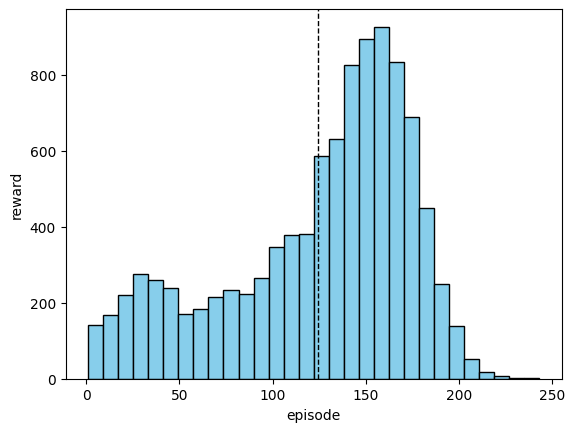

In [ ]:
random.seed(1)
env = OrbitEnv()

# discrete: action: 0 = do nothing, 1 = thrust, 2 = back thrust, 3 = rotate left, 4 = rotate right
# action = random.randint(0, 3)
# continuous: action[0] = how to turn right or left, action[1] = how to thrust
def random_policy(obs):
    return random.randint(0, 2)

totals = []
frames = []

n_episodes = 10_000
for episode in range(n_episodes):
    episode_rewards = 0
    obs = env.reset()
    print("\rEpisode: "+str(episode), end="")
    for step in range(5_001):
        action = random_policy(obs)
        #if step % 50 == 0 and step != 0:
        #     frames.append(env.render(mode = 'rgb_array'))
        obs, reward, done = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

#plot_animation_simple(frames, "space.mp4") # <- If animating
plotError(totals)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


24999--  57.950543314699416


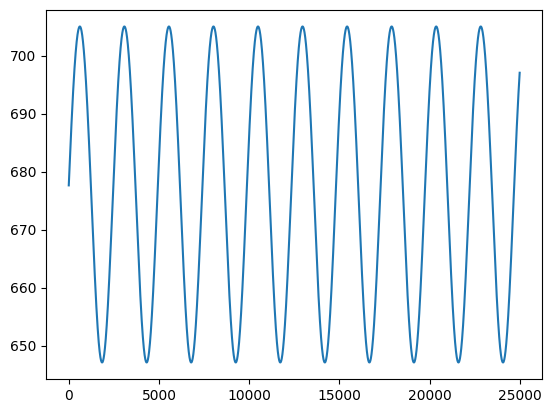

In [ ]:
random.seed(2)
env = OrbitEnv()

# discrete: action: 0 = do nothing, 1 = thrust, 2 = back thrust, 3 = rotate left, 4 = rotate right
# action = random.randint(0, 3)
# continuous: action[0] = how to turn right or left, action[1] = how to thrust
def random_policy(obs, step):
    if step < 1: return 0.0858
    else: return 0.0

totals = []
frames = []
max_steps = 25_000
rs = []

episode_rewards = 0
obs = env.reset()
max_obs = obs[0]
min_obs = max_obs
for step in range(max_steps):

    print("\r"+str(step)+"--  ", end="")
    #print(obs)
    rs.append(obs[0])
    action = [random_policy(obs, step)]
    if step % max_steps == 0 and step != 0:
          frames.append(env.render(mode = 'rgb_array'))
    obs, reward, done = env.step(action)
    if obs[0] < min_obs: min_obs = obs[0]
    if obs[0] > max_obs: max_obs = obs[0]
    episode_rewards += reward
    if done:
        break
totals.append(episode_rewards)

print(max_obs-min_obs)

#plot_animation_simple(frames, "space.mp4") # <- If animating
#plotError(totals)
plt.plot(np.arange(len(rs)), rs)

In [ ]:
random.seed(2)
env = OrbitEnv()

# discrete: action: 0 = do nothing, 1 = thrust, 2 = back thrust, 3 = rotate left, 4 = rotate right
# action = random.randint(0, 3)
# continuous: action[0] = how to turn right or left, action[1] = how to thrust
def random_policy(obs, step):
    if step < 1: return 0.0858
    else: return 0.0

totals = []
frames = []
max_steps = 275_000
rs = []

episode_rewards = 0
obs = env.reset()
for step in range(max_steps):

    print("\r"+str(step)+"--  ", end="")
    #print(obs)
    rs.append(obs[0])
    action = [random_policy(obs, step)]
    if step % 27_500 == 0 and step != 0:
          frames.append(env.render(mode = 'rgb_array'))
    obs, reward, done = env.step(action)
    episode_rewards += reward
    if done:
        break
totals.append(episode_rewards)

#plot_animation_simple(frames, "space.mp4") # <- If animating
#plotError(totals)
#plt.plot(np.arange(len(rs)), rs)

27502--  

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


274999--  

In [ ]:
# Animation of 2,750 steps
plot_animation_simple(frames, "space.mp4")

In [ ]:
# Animation of 25,000 steps ~10 orbits
plot_animation_simple(frames, "space.mp4")

In [ ]:
# Animation of 25,000 steps ~10 orbits
plot_animation_simple(frames, "space.mp4")
plt.plot(np.arange(len(rs)), rs)

## Actor-Critic

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=24):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.network(state)

class Critic(nn.Module):
    def __init__(self, state_size, hidden_size=24):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state):
        return self.network(state)

def test_run(env, actor, num_test_episodes=100):
    total_rewards = []
    for i in range(num_test_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                probs = actor(state)
                action = probs.max(1)[1].view(1, 1)
            next_state, reward, done = env.step(action.item())
            episode_reward += reward
            state = next_state
        total_rewards.append(episode_reward)
        if i == num_test_episodes-1: print(f"\t Total Rewards = {total_rewards}", end="")
    average_reward = np.mean(total_rewards)
    print(f"\nAverage Testing Reward: {average_reward}")
    return average_reward

def train(env, actor, actor_filename, critic, critic_filename, actor_optimizer, critic_optimizer, max_steps=500, n_episodes=183, gamma=0.995):
    start_time = time.time()
    all_rewards = []
    all_actor_losses = []
    all_critic_losses = []
    old_rew = 0
    t = 0
    for episode in range(n_episodes):
        random.seed(1)
        state = env.reset()
        done = False
        log_probs = []
        values = []
        rewards = []
        actions = {0: 0, 1: 0, 2: 0, 3: 0}
        episode_reward = 0
        t2 = 0

        # Play through one episode
        while not done:
            print("\r"+str(episode)+"\t"+str(t)+"\t"+str(t2)+"\t"+str(state), end="")
            state = torch.FloatTensor(state).unsqueeze(0)
            probs = actor(state)
            value = critic(state)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()

            next_state, reward, done = env.step(action.item())
            actions[action.item()] += 1
            episode_reward += reward

            log_probs.append(dist.log_prob(action)) # Prob of our action
            values.append(value) # Value Critic assigned to the current state
            rewards.append(torch.tensor([reward], dtype=torch.float)) # Reward of next state

            state = next_state
            t += 1
            t2 += 1

        # Calculate adjusted returns of all the starts based on length of episode
        returns = []
        all_rewards.append(episode_reward)
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)

        returns = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs)
        values = torch.cat(values)

        advantage = returns - values # Diff b/w Critics expected Value and actual adjusted Value

        # Adjust for loss
        actor_loss = -(log_probs * advantage.detach()).mean() # Descend loss where loss = confidence in action * how far the expected value was from actual adjusted value to adjust actor model
        critic_loss = advantage.pow(2).mean() # MSE of difference to adjust critic model

        all_actor_losses.append(actor_loss.item())
        all_critic_losses.append(critic_loss.item())

        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        actor_optimizer.step()
        critic_optimizer.step()

        # Print Episode #, Loss, and Test Reward
        print('\rEpisode {}\t Actor Loss: {:.2f} Critic Loss {:.2f} \t Episode Reward {} \t Actions {}' \
          .format(episode, actor_loss.item(), critic_loss.item(), episode_reward, actions))
        if episode % 100 == 0 and episode != 0:
            print('\rEpisode {}\t Actor Loss: {:.2f} Critic Loss {:.2f} \t Avg Episode Reward {} \t Actions {}' \
              .format(episode, np.mean(all_actor_losses[-100:]), np.mean(all_critic_losses[-100:]), np.mean(all_rewards[-100:]), actions), end="")
            #visualize_action_output(actor, x_range=(-2, 2), theta_range=(-2, 2))
            #visualize_action_output(critic, x_range=(-2, 2), theta_range=(-2, 2))

        #if episode % 50 == 0 and episode != 0:
            #avg_rew = test_run(env, actor)
            #if avg_rew == max_steps and old_rew == max_steps:
              #break
            #old_rew = avg_rew

    #avg_rew = test_run(env, actor)
    time_taken = time.time() - start_time
    print(f"\n---- TRAINING DONE IN {round(time_taken, 2)} SECONDS ----")
    print(" ")

    torch.save(actor.state_dict(), actor_filename)
    torch.save(critic.state_dict(), critic_filename)

    return all_rewards, time_taken

In [ ]:
def trainModel(env, hidden_size, max_steps, n_episodes, actor_filename, critic_filepath):
    state_size = 4
    action_size = 3

    actor = Actor(state_size, action_size, hidden_size=hidden_size)
    critic = Critic(state_size, hidden_size=hidden_size)

    actor_optimizer = optim.AdamW(actor.parameters(), lr=1e-2, weight_decay=0.03)
    critic_optimizer = optim.AdamW(critic.parameters(), lr=1e-4, weight_decay=0.03)

    all_rewards, time_taken = train(env, actor, actor_filename, critic, critic_filepath, actor_optimizer, critic_optimizer, max_steps, n_episodes)

    return all_rewards, time_taken, actor

In [ ]:
max_steps = 1_000
n_episodes = 183
hidden_size = 10
random.seed(1)
env = OrbitEnv()

all_rewards, time_taken, _ = trainModel(env, hidden_size, max_steps, n_episodes, f'actor_{hidden_size}.pth', f'critic_{hidden_size}.pth')

Episode 0	 Actor Loss: 117.72 Critic Loss 13788.40 	 Episode Reward 360 	 Actions {0: 94, 1: 143, 2: 123, 3: 0}
Episode 1	 Actor Loss: 165.09 Critic Loss 25295.55 	 Episode Reward 792 	 Actions {0: 234, 1: 293, 2: 265, 3: 0}
Episode 2	 Actor Loss: 59.43 Critic Loss 3653.19 	 Episode Reward 131 	 Actions {0: 44, 1: 46, 2: 41, 3: 0}
Episode 3	 Actor Loss: 58.97 Critic Loss 3653.17 	 Episode Reward 131 	 Actions {0: 41, 1: 49, 2: 41, 3: 0}
Episode 4	 Actor Loss: 123.15 Critic Loss 14901.47 	 Episode Reward 389 	 Actions {0: 133, 1: 146, 2: 110, 3: 0}
Episode 5	 Actor Loss: 130.54 Critic Loss 16379.42 	 Episode Reward 430 	 Actions {0: 152, 1: 148, 2: 130, 3: 0}
Episode 6	 Actor Loss: 92.13 Critic Loss 8730.81 	 Episode Reward 242 	 Actions {0: 79, 1: 90, 2: 73, 3: 0}
Episode 7	 Actor Loss: 97.08 Critic Loss 9638.30 	 Episode Reward 262 	 Actions {0: 81, 1: 104, 2: 77, 3: 0}
Episode 8	 Actor Loss: 60.13 Critic Loss 3783.37 	 Episode Reward 134 	 Actions {0: 42, 1: 46, 2: 46, 3: 0}
Episode 

## Trying with PPO

In [ ]:
def visualize_action_output(actor, x_range, theta_range, resolution=100):
    x_values = np.linspace(x_range[0], x_range[1], resolution)
    theta_values = np.linspace(theta_range[0], theta_range[1], resolution)
    action_outputs = np.zeros((resolution, resolution))

    for i, x in enumerate(x_values):
        for j, theta in enumerate(theta_values):
            state = torch.tensor([[x, theta, 0, 0]], dtype=torch.float)
            with torch.no_grad():
                action = actor.select_action(state, False)
                #print("action, "+str(action))
            action_outputs[j, i] = action

    plt.figure(figsize=(10, 6))
    X, Y = np.meshgrid(x_values, theta_values)
    plt.contourf(X, Y, action_outputs, 20, cmap='RdYlBu')
    plt.colorbar()
    plt.xlabel('radius')
    plt.ylabel('theta')
    plt.title('Action Output Visualization')
    plt.show()

In [ ]:
# Memory to storing history of transitions
class ReplayBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


# One model with the Actor *and* Critic networks bundled together
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()
        # Works now for both continuous and discrete action states
        self.has_continuous_action_space = has_continuous_action_space
        self.action_dim = action_dim
        self.action_var = torch.full((action_dim,), action_std_init * action_std_init)

        # Actor
        if has_continuous_action_space :
            # Output range [-1, 1]

            self.actor = nn.Sequential(
                            nn.Linear(state_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, action_dim),
                            nn.Tanh())
        else:
            # Output discrete n = action_dim actions
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, action_dim),
                            nn.Softmax(dim=-1))

        # Critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, 1))


    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std)
        else:
          print("WARNING : Called ActorCritic::set_action_std() on discrete action space")


    def act(self, state):
        if self.has_continuous_action_space:
            action_mean = self.actor(state)  # Assume output is [action_1_mean, action_2_mean] for 2 actions
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
            action = dist.sample()
            action = torch.clamp(action, -1, 1)  # Ensure actions are within expected range
            action_logprob = dist.log_prob(action)
        else:
            action_probs = self.actor(state)[0]
            dist = Categorical(action_probs)
            action = dist.sample()
            action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()


    def evaluate(self, state, action):
        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):
        self.has_continuous_action_space = has_continuous_action_space
        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma # discount of past reward
        self.eps_clip = eps_clip # for clipping values to prevent math issues
        self.epochs = epochs
        self.memory = ReplayBuffer()
        self.policy = ActorCritic(state_dim, action_dim, hidden_dim, has_continuous_action_space, action_std_init)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor, 'betas': (0.99, 0.99), 'weight_decay': 0.03},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic, 'betas': (0.99, 0.99), 'weight_decay': 0.03}
                    ])
        self.policy_old = ActorCritic(state_dim, action_dim, hidden_dim, has_continuous_action_space, action_std_init)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("WARNING : Called PPO::set_action_std() on discrete action space")


    def decay_action_std(self, action_std_decay_rate, min_action_std):

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Called PPO::decay_action_std() on discrete action space")


    def select_action(self, state, save):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            action, action_logprob, state_val = self.policy_old.act(state)

        if save:
            self.memory.states.append(state)
            self.memory.actions.append(action)
            self.memory.logprobs.append(action_logprob)
            self.memory.state_values.append(state_val)

        if self.has_continuous_action_space:
            return action.cpu().numpy().flatten()  # For continuous, return as array
        else:
            return action.item()  # For discrete, return a single item


    def update(self, batch_size):
        # Convert list to tensor
        rewards = torch.tensor(self.memory.rewards, dtype=torch.float32)

        # Normalize rewards
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.stack(self.memory.states).detach()
        old_actions = torch.stack(self.memory.actions).detach()
        old_logprobs = torch.stack(self.memory.logprobs).detach()

        # Create TensorDataset and DataLoader to sample
        dataset = TensorDataset(old_states, old_actions, old_logprobs, rewards)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Optimize policy for K epochs:
        for k in range(self.epochs):
            print(k, end=" ")
            for state, action, old_logprob, reward in dataloader:
                logprobs, state_values, dist_entropy = self.policy.evaluate(state, action)
                state_values = torch.squeeze(state_values)

                ratios = torch.exp(logprobs - old_logprob.detach())

                advantages = reward - state_values.detach()
                surr1 = ratios * advantages
                surr2 = torch.clamp(ratios, 1.0 - self.eps_clip, 1.0 + self.eps_clip) * advantages
                loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, reward) - 0.01 * dist_entropy

                # Take gradient step
                self.optimizer.zero_grad()
                loss.mean().backward()
                print("\r"+str(loss.mean()), end="")
                self.optimizer.step()

            # Optionally, you can print the progress here (inside the epoch loop)

        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())

        # Clear memory
        self.memory.clear()
        print(f"\t successfully cleared memory= {len(self.memory.actions)==0}")


    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
####### setup #######
has_continuous_action_space = True  # continuous action space; else discrete
max_ep_len =  10_000                 # max timesteps in one episode
max_training_timesteps = 1_000_000  # break training loop if timeteps > max_training_timesteps
print_freq = max_ep_len * 5         # how often (in timesteps) to print avg reward
log_freq = max_ep_len * 5           # how often (in timesteps) to print log avg reward
save_model_freq = max_ep_len * 15   # how often (in timesteps) to save model
update_timestep = max_ep_len * 5    # how often (in timesteps) to update policy

epochs = 1                          # how many (in epochs) to run on updating PPO
eps_clip = 0.2                      # parameter for value clipping

action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # action_std = action_std - action_std_decay_rate
min_action_std = 0.1                # minimum action_std
action_std_decay_freq = 25_000      # how often (in timesteps) to decay action_std
gamma = 0.995                       # discount factor for considering past summed rewards in value of current state
lr_actor = 0.03                     # lr for actor #CHANGED TO e-2 FROM e-4
lr_critic = 0.03                    # lr for critic
hidden_dim = 10
batch_size = 10_000

random.seed()
show_path = True

random_seed = random.randint(3, 9)  # seed (can be set to random number, currently set to 0)

env_name = "Orbit-v1" # env name to save model under
print("training environment name : " + env_name)

state_dim = 1                              # (r, θ)    (r, θ, |v|, v_θ)                                 (x, y, θ, x_vel, y_vel)+(r, x*y)
action_dim = 1

####### logging #######
# don't overwrite old log files
log_dir = "PPO_logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)
log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

# num of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)

####### checkpointing #######
# don't overwrite old weights
run_num_pretrained = 0

directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)
directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)

checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)

####### training procedure #######
ppo_agent = PPO(state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, epochs, eps_clip, has_continuous_action_space, action_std)
start_time = datetime.now().replace(microsecond=0)

print("Started training at (GMT) : ", start_time)
print("============================================================================================")

print_running_reward = 0
print_running_episodes = 0

# training loop
rewards = []
frames = []

time_step = 0
i_episode = 0
random.seed(1)
env = OrbitEnv()

print_running_reward = 0
print_running_episodes = 0

start_time = time.time()
rewards = []
old_rew = 0
time_step = 0
while time_step <= max_training_timesteps:
    random.seed(1)
    state = env.reset()
    print("starter state-- "+str(state))
    done = False
    log_probs = []
    values = []
    rewards = []
    episode_reward = 0
    current_ep_reward = 0

    # Play through one episode
    for t in range(1, max_ep_len+1):
        print("\r"+str(time_step)+"\t"+str(t)+"\t"+str(state), end="")

        action = ppo_agent.select_action(state, True)
        next_state, reward, done = env.step(action)

        # register new step
        ppo_agent.memory.rewards.append(reward)
        ppo_agent.memory.is_terminals.append(done)
        time_step +=1
        current_ep_reward += reward

        print_avg_reward = print_running_reward / print_running_episodes if print_running_episodes != 0 else 0
        print_avg_reward = round(print_avg_reward, 2)

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update(batch_size)

        # decay action_std when necessary
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # print avg reward
        if time_step % print_freq == 0:
            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))
            visualize_action_output(ppo_agent, x_range=(-1000, 1000), theta_range=(0, 360))
            #visualize_action_output(critic, x_range=(-2, 2), theta_range=(-2, 2))
            print_running_reward = 0
            print_running_episodes = 0

        # save weights
        if time_step % save_model_freq == 0 and print_avg_reward == max_ep_len:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            time_step = max_training_timesteps
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")

        if done:
            rewards.append(current_ep_reward)
            print(f"\tFinished in {t} steps")
            break

        state = next_state

    print_running_reward += current_ep_reward
    print_running_episodes += 1
    i_episode += 1


# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")

Streaming output truncated to the last 5000 lines.
332841	11	[446.81216236748776]	Finished in 11 steps
starter state-- [308.8251932728287]
332854	13	[449.4543175523596]	Finished in 13 steps
starter state-- [308.8251932728287]
332864	10	[445.49897254811555]	Finished in 10 steps
starter state-- [308.8251932728287]
332876	12	[450.717425755274]	Finished in 12 steps
starter state-- [308.8251932728287]
332888	12	[448.32019875295373]	Finished in 12 steps
starter state-- [308.8251932728287]
332898	10	[445.49897254811555]	Finished in 10 steps
starter state-- [308.8251932728287]
332908	10	[445.49897254811555]	Finished in 10 steps
starter state-- [308.8251932728287]
332919	11	[438.52316696646363]	Finished in 11 steps
starter state-- [308.8251932728287]
332931	12	[441.49498387205415]	Finished in 12 steps
starter state-- [308.8251932728287]
332941	10	[440.0274428827817]	Finished in 10 steps
starter state-- [308.8251932728287]
332951	10	[445.49897254811555]	Finished in 10 steps
starter state-- [308.

KeyboardInterrupt: 